# Introdução

O presente relatório descreve a aplicação do método _Linear Programming Discriminant Analysis (LPDA)_ conforme proposto no artigo intitulado **"LPDA: A new classification method based on linear programming"**. O objetivo principal deste trabalho é desenvolver um modelo de classificação binária utilizando o LPDA em um conjunto de dados previamente selecionado, disponível na pasta "data".

O artigo também apresenta uma biblioteca em R que oferece métodos para a implementação do LPDA. A documentação completa dessa biblioteca pode ser encontrada no CRAN, no seguinte endereço: [pacote lpda](https://cran.r-project.org/web/packages/lpda/index.html).

No entanto, devido às complexidades associadas à conversão do código R para Python e às particularidades das estruturas de dados utilizadas pela biblioteca, optou-se por empregar a biblioteca [Pulp](https://coin-or.github.io/pulp/). Essa biblioteca possibilita a descrição iterativa do problema de programação linear a ser resolvido, oferecendo a opção de utilizar o solver de preferência do usuário. Outras ferramentas, como [AMPL](https://ampl.com/), seguem uma abordagem semelhante.

# Metodologia

A implementação do LPDA utilizando a biblioteca Pulp permitiu resolver o problema de programação linear, encontrando a solução ótima. Os coeficientes do plano H descritos no artigo, bem como a constante 'b', foram obtidos como resultado. Adicionalmente, foram desenvolvidos métodos para armazenar esses valores em disco, possibilitando sua reutilização posterior.

Com o arquivo do modelo armazenado, foi possível criar um servidor de aplicação que oferece duas rotas principais:

1. **Treinamento:** A rota `POST /heart/train` realiza o treinamento do modelo. Exemplo de chamada:
   ```bash
   !curl --request POST --url http://localhost:8080/heart/train
2. **Predição:** A rota `POST /heart/predict` permite realizar previsões com base no modelo treinado. Exemplo de chamada:

   ```bash
   !curl --request POST \
   --url http://localhost:8080/heart/predict \
   --header 'Content-Type: application/json' \
   --data '{
    "age": 19,
    "sex": 0,
    "cp": 1,
    "trestbps": 120,
    "chol": 204,
    "fbs": 0,
    "restecg": 0,
    "thalach": 172,
    "exang": 0,
    "oldpeak": 1.4,
    "slope": 2,
    "ca": 0,
    "thal": 2
   }'

### Como Rodar

1. Instalar Python >= 3.9 ([Download Python](https://www.python.org/))
2. Instalar Poetry ([Download Poetry](https://python-poetry.org/))
3. `cd code`
4. `poetry install`
5. `poetry shell`

### Rodar como servidor de aplicação:

- `python .\src\main.py`

### Rodar como aplicação standalone para validação do modelo:

- `python .\src\test.py`


In [1]:
import pandas as pd 
import numpy as np
from train.lpda import lpda, simple_predict, predict
import matplotlib.pyplot as plt
import seaborn as sb
from test import main

In [22]:
file2 = '..\data\diabetes\diabetes_binary_5050split_health_indicators_BRFSS2021.csv'
file1 = '..\data\heart_disease\heart.csv'
df = pd.read_csv(file1)
df_teste = pd.read_csv(file2)

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\elisb\AppData\Local\Temp\ipykernel_2864\2145957775.py:1: SyntaxWarning: invalid escape sequence '\d'
  file2 = '..\data\diabetes\diabetes_binary_5050split_health_indicators_BRFSS2021.csv'
C:\Users\elisb\AppData\Local\Temp\ipykernel_2864\2145957775.py:2: SyntaxWarning: invalid escape sequence '\d'
  file1 = '..\data\heart_disease\heart.csv'


cp = nivel de dor no peito
trestbps = Pressão arterial em repouso
chol = Colesterol no soro sangüíneo
fbs = concentração de acuçar no sangue
restecg = eletrocardiografia em repouso
thalach = a taxa de batimento cardíaco
exang = Angina induzida por exercício
oldpeak = Depressão ST induzida por exercício relativamente sossegado
slope = Inclinação da extremidade do segmento ST no exercício
ca = Número de vasos coloridos pela fluoroscopia
thal = Talassemias
target = resultado

In [23]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [25]:
df.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


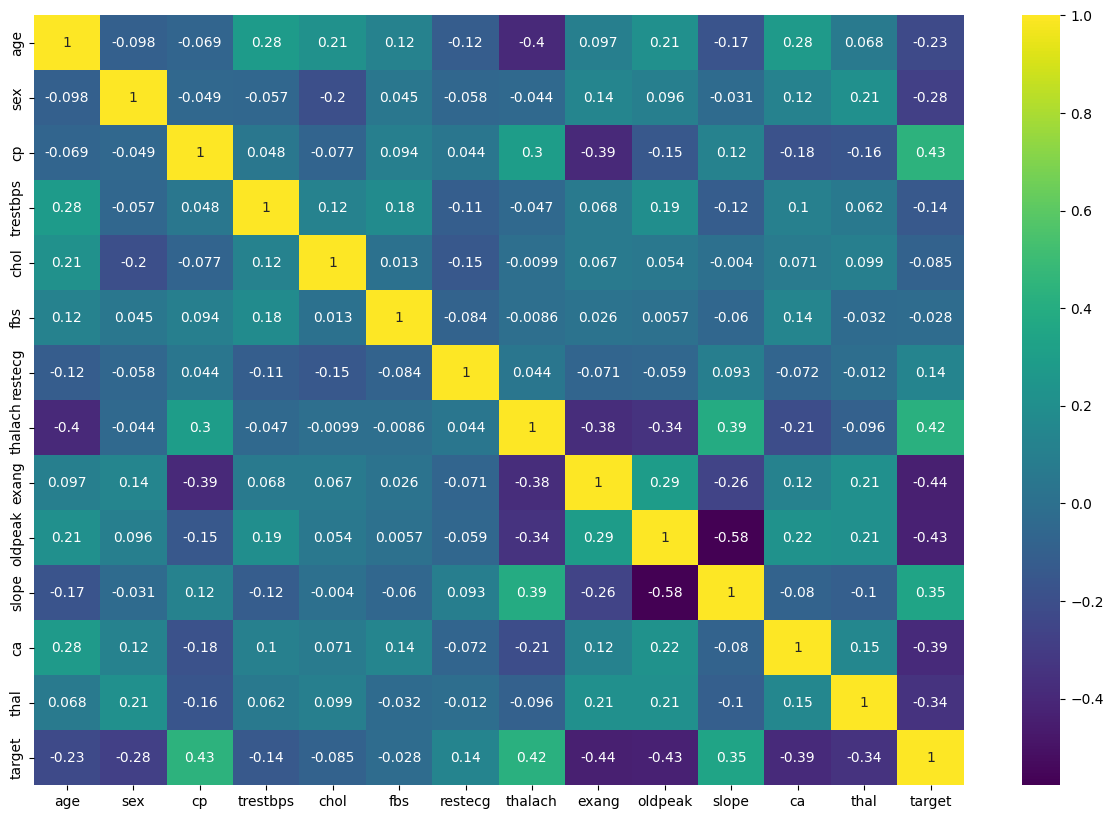

In [30]:
plt.figure(figsize=(15, 10))
sb.heatmap(df.corr(), annot=True, cmap="viridis");

In [105]:
df_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67136 entries, 0 to 67135
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       67136 non-null  float64
 1   HighBP                67136 non-null  int64  
 2   HighChol              67136 non-null  float64
 3   CholCheck             67136 non-null  int64  
 4   BMI                   67136 non-null  float64
 5   Smoker                67136 non-null  float64
 6   Stroke                67136 non-null  float64
 7   HeartDiseaseorAttack  67136 non-null  float64
 8   PhysActivity          67136 non-null  int64  
 9   Fruits                67136 non-null  int64  
 10  Veggies               67136 non-null  int64  
 11  HvyAlcoholConsump     67136 non-null  int64  
 12  AnyHealthcare         67136 non-null  int64  
 13  NoDocbcCost           67136 non-null  float64
 14  GenHlth               67136 non-null  float64
 15  MentHlth           

In [108]:
colunas = ['AnyHealthcare', 'NoDocbcCost', 'Education', 'Income']
df_teste = df_teste.drop(colunas, axis=1)

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Supondo que 'df_teste' seja seu DataFrame

# Separar as características (X) e a variável alvo (y)
X = df_teste.drop('Diabetes_binary', axis=1)
y = df_teste['Diabetes_binary']

# Dividir o conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar e treinar o modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = rf_model.predict(X_test)

# Avaliar o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo: {accuracy:.2f}')

# Exibir relatório de classificação
print('\nRelatório de Classificação:\n', classification_report(y_test, y_pred))

# Exibir importância das características
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print('\nImportância das Características:\n', feature_importance_df)


Acurácia do modelo: 0.72

Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.73      0.68      0.70      6614
         1.0       0.71      0.75      0.73      6814

    accuracy                           0.72     13428
   macro avg       0.72      0.72      0.72     13428
weighted avg       0.72      0.72      0.72     13428


Importância das Características:
                  Feature  Importance
3                    BMI    0.215854
16                   Age    0.169259
11               GenHlth    0.107679
0                 HighBP    0.081497
13              PhysHlth    0.081051
12              MentHlth    0.079983
1               HighChol    0.039388
8                 Fruits    0.034085
4                 Smoker    0.033520
15                   Sex    0.030246
14              DiffWalk    0.027164
9                Veggies    0.025614
7           PhysActivity    0.024286
6   HeartDiseaseorAttack    0.019498
10     HvyAlcoholConsump    

In [112]:
lista = feature_importance_df['Feature'].tolist()
print(lista)

['BMI', 'Age', 'GenHlth', 'HighBP', 'PhysHlth', 'MentHlth', 'HighChol', 'Fruits', 'Smoker', 'Sex', 'DiffWalk', 'Veggies', 'PhysActivity', 'HeartDiseaseorAttack', 'HvyAlcoholConsump', 'Stroke', 'CholCheck']


In [130]:
df_teste_filter = df_teste[['Diabetes_binary','BMI', 'Age', 'GenHlth', 'HighBP', 'PhysHlth', 'MentHlth', 'HighChol', 'Fruits', 'Smoker', 'Sex', 'DiffWalk', 'Veggies', 'PhysActivity', 'HeartDiseaseorAttack']]

In [125]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Supondo que 'df_teste_filter' seja seu DataFrame

# Separar as características (X) e a variável alvo (y)
X = df_teste_filter.drop('Diabetes_binary', axis=1)
y = df_teste_filter['Diabetes_binary']

# Dividir o conjunto de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar e treinar o modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = rf_model.predict(X_test)

# Avaliar o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo: {accuracy:.2f}')

# Exibir relatório de classificação
print('\nRelatório de Classificação:\n', classification_report(y_test, y_pred))

# Exibir importância das características
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df2 = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df2 = feature_importance_df2.sort_values(by='Importance', ascending=False)
print('\nImportância das Características:\n', feature_importance_df2)

Acurácia do modelo: 0.70

Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.70      0.68      0.69      6614
         1.0       0.69      0.72      0.71      6814

    accuracy                           0.70     13428
   macro avg       0.70      0.70      0.70     13428
weighted avg       0.70      0.70      0.70     13428


Importância das Características:
                 Feature  Importance
0                   BMI    0.252268
1                   Age    0.177953
2               GenHlth    0.141173
4              PhysHlth    0.114894
5              MentHlth    0.114679
3                HighBP    0.108764
6              HighChol    0.041764
7              DiffWalk    0.030016
8  HeartDiseaseorAttack    0.018490


In [126]:
feature_importance_df

,Feature,Importance
3,BMI,0.215854
16,Age,0.169259
11,GenHlth,0.107679
0,HighBP,0.081497
13,PhysHlth,0.081051
12,MentHlth,0.079983
1,HighChol,0.039388
8,Fruits,0.034085
4,Smoker,0.033520
15,Sex,0.030246


In [127]:
feature_importance_df2

,Feature,Importance
0,BMI,0.252268
1,Age,0.177953
2,GenHlth,0.141173
4,PhysHlth,0.114894
5,MentHlth,0.114679
3,HighBP,0.108764
6,HighChol,0.041764
7,DiffWalk,0.030016
8,HeartDiseaseorAttack,0.018490


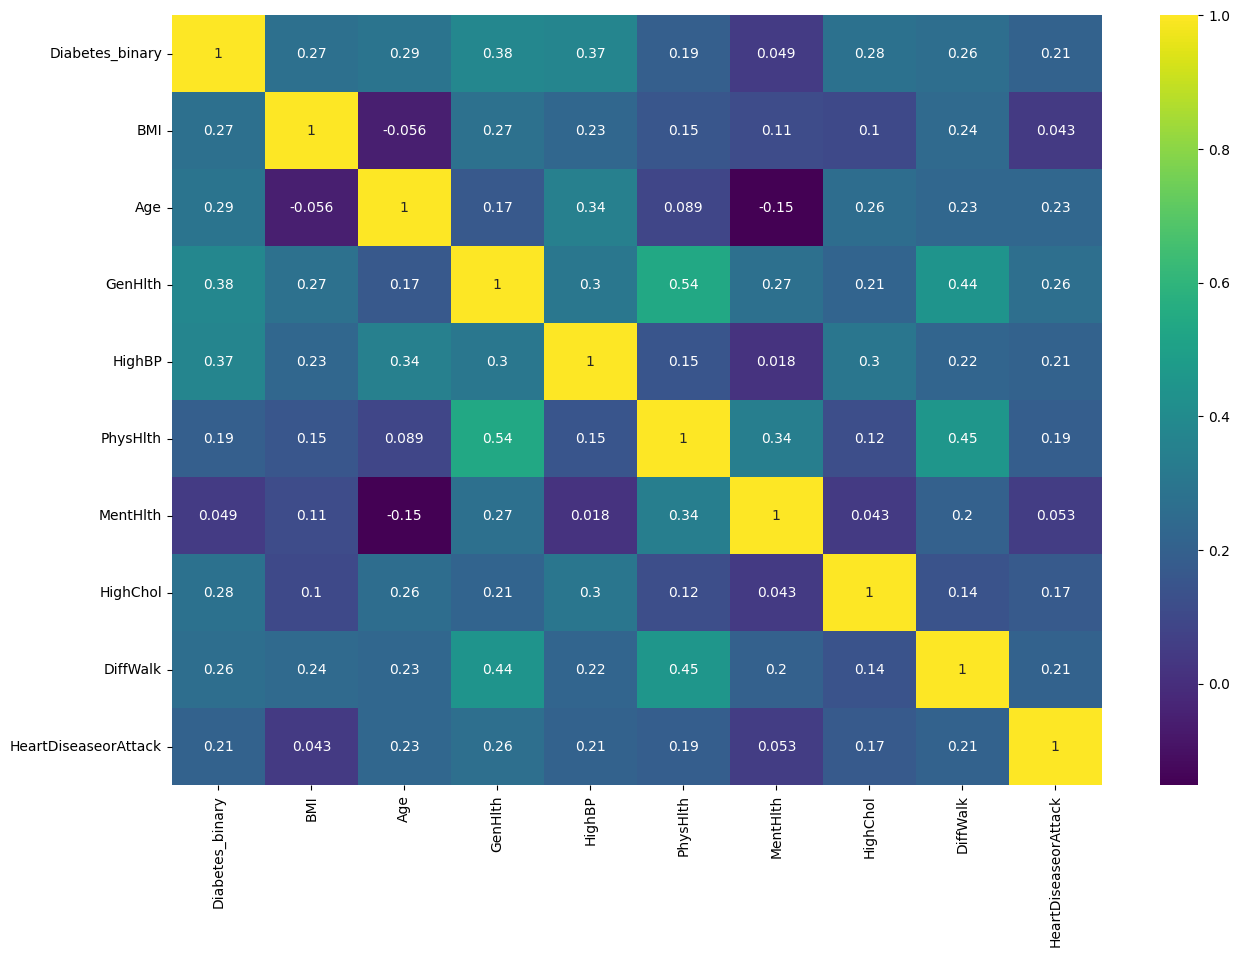

In [128]:
plt.figure(figsize=(15, 10))
sb.heatmap(df_teste_filter.corr(), annot=True, cmap="viridis");

In [131]:
result = main(df_teste_filter, 'Diabetes_binary')
print(result)

Solution: 
	a = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.7496866e-11, 0.0, 0.0, 0.0, 6.1092152e-12, 2.0, 0.0]
	b = 1.0


Test set: 
	X_test = [[25.  9.  2. ...  1.  1.  0.]
 [22.  5.  2. ...  1.  1.  0.]
 [23.  9.  1. ...  0.  1.  0.]
 ...
 [24.  9.  1. ...  1.  1.  0.]
 [30. 12.  3. ...  1.  1.  0.]
 [29.  8.  2. ...  0.  1.  0.]]
	y_test = [[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]


Scores: 
	Precision: 0.6508313539192399
	Accuracy: 0.6508313539192399
	F1 score: 0.4695801199657241



In [41]:
result_heart = main(df_filtered, 'target')
print(result_heart)

Solution: 
	a = [1.0629333, 0.0, 0.0036013325, 0.0, 0.0, 0.0, 1.3438372, 0.49158189, 0.0, 0.74205456, 0.44656523]
	b = 4.1120915


Test set: 
	X_test = [[1.00e+00 3.00e+00 2.73e+02 0.00e+00 0.00e+00 1.25e+02 0.00e+00 0.00e+00 2.00e+00 0.00e+00 2.00e+00]
 [1.00e+00 0.00e+00 2.49e+02 0.00e+00 0.00e+00 1.44e+02 0.00e+00 8.00e-01 2.00e+00 0.00e+00 3.00e+00]
 [1.00e+00 2.00e+00 3.35e+02 0.00e+00 1.00e+00 1.58e+02 0.00e+00 0.00e+00 2.00e+00 0.00e+00 2.00e+00]
 [1.00e+00 0.00e+00 2.16e+02 0.00e+00 0.00e+00 1.31e+02 1.00e+00 2.20e+00 1.00e+00 3.00e+00 3.00e+00]
 [1.00e+00 2.00e+00 3.09e+02 0.00e+00 1.00e+00 1.31e+02 1.00e+00 1.80e+00 1.00e+00 0.00e+00 3.00e+00]
 [1.00e+00 0.00e+00 2.89e+02 0.00e+00 0.00e+00 1.45e+02 1.00e+00 8.00e-01 1.00e+00 1.00e+00 3.00e+00]
 [1.00e+00 2.00e+00 2.43e+02 0.00e+00 1.00e+00 1.52e+02 0.00e+00 0.00e+00 2.00e+00 0.00e+00 2.00e+00]
 [1.00e+00 2.00e+00 2.18e+02 1.00e+00 1.00e+00 1.34e+02 0.00e+00 2.20e+00 1.00e+00 1.00e+00 1.00e+00]
 [1.00e+00 0.00e+00 2.34e+02 0.0

In [42]:
result_heart2 = main(df, 'target')
print(result_heart2)

Solution: 
	a = [0.013748104, 1.1251695, 0.0, 0.0, 0.0039203577, 0.0, 0.0, 0.0, 1.3843964, 0.46359572, 0.0, 0.70430837, 0.45532538]
	b = 4.9093753


Test set: 
	X_test = [[5.90e+01 1.00e+00 3.00e+00 1.60e+02 2.73e+02 0.00e+00 0.00e+00 1.25e+02 0.00e+00 0.00e+00 2.00e+00 0.00e+00 2.00e+00]
 [4.60e+01 1.00e+00 0.00e+00 1.20e+02 2.49e+02 0.00e+00 0.00e+00 1.44e+02 0.00e+00 8.00e-01 2.00e+00 0.00e+00 3.00e+00]
 [6.40e+01 1.00e+00 2.00e+00 1.40e+02 3.35e+02 0.00e+00 1.00e+00 1.58e+02 0.00e+00 0.00e+00 2.00e+00 0.00e+00 2.00e+00]
 [5.80e+01 1.00e+00 0.00e+00 1.28e+02 2.16e+02 0.00e+00 0.00e+00 1.31e+02 1.00e+00 2.20e+00 1.00e+00 3.00e+00 3.00e+00]
 [6.40e+01 1.00e+00 2.00e+00 1.25e+02 3.09e+02 0.00e+00 1.00e+00 1.31e+02 1.00e+00 1.80e+00 1.00e+00 0.00e+00 3.00e+00]
 [5.50e+01 1.00e+00 0.00e+00 1.60e+02 2.89e+02 0.00e+00 0.00e+00 1.45e+02 1.00e+00 8.00e-01 1.00e+00 1.00e+00 3.00e+00]
 [4.70e+01 1.00e+00 2.00e+00 1.08e+02 2.43e+02 0.00e+00 1.00e+00 1.52e+02 0.00e+00 0.00e+00 2.00e+00 0.00e+00 

# Resultados

# Conclusão